# TODO:
        1a) further location cleaning / explanations for tfidf and count (and f1/precision/recall)
        1b) best way to present acc/prec/recall/f1 comparisons???
        1c) n-gram viz thing
        2) which countries most accurate in?
        3) why does RF and NB do better with count?
        4) BERT? maybe?
        6) train unique RNN? ehhhhh

In [268]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [269]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [270]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1) Load in data

In [271]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [272]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning

In [273]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [274]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [275]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [276]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [277]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [278]:
test = tokenizer.tokenize(df['newTweet'][1])
[stemmer.stem(word) for word in test][0:3]

['advic', 'talk', 'neighbour']

In [279]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [280]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [281]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [282]:
token_stem(tweet)

'advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order'

In [283]:
token_lemma(tweet)

'advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order'

In [284]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))

In [285]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [286]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [287]:
# Sanity check
print(make_label('Extremely Negative'))
print(make_label('Extremely Positive'))
print(make_label('Neutral'))

-1
1
0


In [288]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


### 2a) Location Cleaning

In [289]:
# Value counts for general idea of location data
df['Location'].value_counts()

None                             8590
London                            540
United States                     528
London, England                   520
New York, NY                      395
                                 ... 
Highland, CA                        1
Newnan, GA                          1
Catalonia                           1
WEST SACRAMENTO,  CALIFORNIA        1
Mesquite, TX                        1
Name: Location, Length: 12221, dtype: int64

In [290]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD')

In [291]:
# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', )
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia')
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [292]:
# Changing strings found with filters into 3 digit codes
df['newLoc'] = df['Location'].apply(lambda x: 'USA' if x in us_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'IND' if x in india_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'FRA' if x in france_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['newLoc'] = df['newLoc'].apply(lambda x: 'None' if x in other_filters else x)

In [293]:
# View results
df['newLoc'].value_counts()[0:20]

None                   8969
USA                    4617
GBR                    1949
IND                     683
CAN                     588
AUS                     584
UK                      232
NGA                     212
ZAF                     178
KEN                     144
FRA                     101
SGP                      87
NZL                      75
IRL                      61
UGA                      58
MYS                      50
PAK                      45
North Carolina, USA      41
Dubai                    40
Hong Kong                40
Name: newLoc, dtype: int64

Further cleaning can obviously be done here, but this has captured most of the 'easy to grab' data. In the interest of my time and sanity, this is fine.

In [294]:
# 0:17 because that's where the labeled countries end
places_df = pd.DataFrame(df['newLoc'].value_counts()[0:17])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'newLoc':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

Plotly visualization of tweets...not all too useful. My guess is that this data was pulled mainly from English speaking countries, as that's where the majority of tweets come from.  Also, considering the data was manually labeled, they probably stuck to only English tweets.

fig = go.Figure(data=go.Choropleth(
    locations = places_df['Country'],
    z = places_df['Tweets'],
    text = places_df['Country'],
    #colorscale = 'Greens',
    autocolorscale=True,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'Number of Tweets',
))
fig.update_layout(
    title_text='Coronavirus Tweets',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)

fig.show()

In [295]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [296]:
iplot(choromap)

## 3) Wordcloud

In [297]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
mask = np.array(Image.open("rona4.jpeg"))

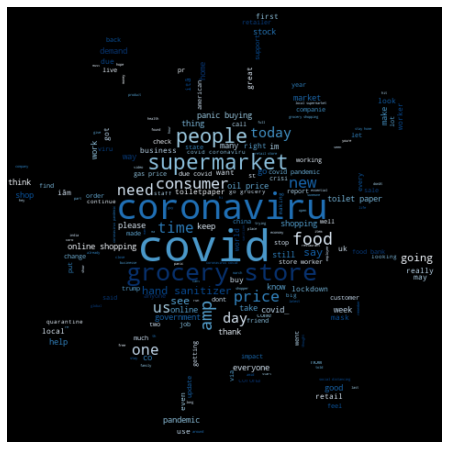

In [298]:
text = df['newTweet'].to_string(index = False)
text = re.sub(r'\n','',text)
wordcloud = WordCloud(colormap = 'Blues', mask = mask).generate(text)
plt.figure(figsize = (10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [299]:
# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

In [300]:
# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text

(-0.5, 473.5, 473.5, -0.5)

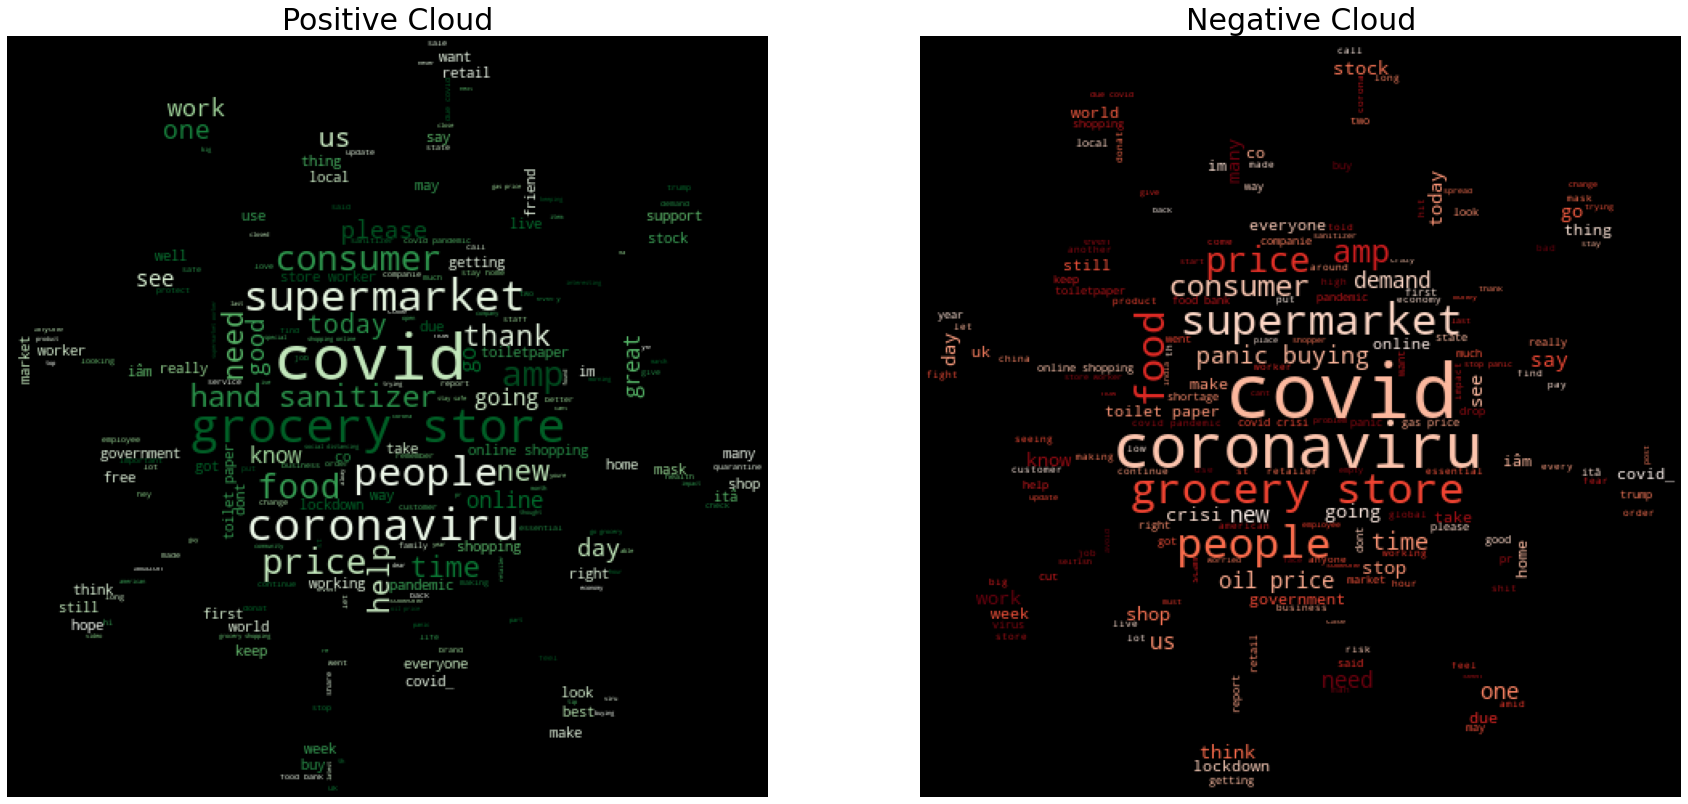

In [301]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neg_cloud)
ax2.set_title('Negative Cloud', fontsize = 30)
ax2.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'super market', and 'online shopping' being frequent in both positive and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

## 4) Classification

In [302]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [303]:
# Define dictionary of classification methods.
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [304]:
# Function that will iterate through models and print 
# classifcation reports and accuracies for each model.
def models(clf, vectorizer, X_train, X_test, y_train, y_test):
    """
    Input:
        clf: dictionary containing classification methods
        vectorizer: ex TfidfVectorizer, CountVectorizer
        X_train: X training data
        X_test: X testing data
        y_train: y training labels
        y_test: y testing label
    
    Output: 
        output_df: a DataFrame containing the weighted average
        accuracy, precision, recall, and f1 score of each method
    """
    
    accuracy_dict = {}
    clf_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier]),
                    ])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        accuracy_dict[classifier] = accuracy_score(y_test,preds)
        clf_dict[classifier] = classification_report(y_test,preds, output_dict = True)
        precision_dict[classifier] = clf_dict[classifier]['weighted avg']['precision']
        recall_dict[classifier] = clf_dict[classifier]['weighted avg']['recall']
        f1_dict[classifier] = clf_dict[classifier]['weighted avg']['f1-score']
           
        print(classifier)
        print(classification_report(y_test,preds))
        print(classifier + ' Accuracy:', accuracy_score(y_test,preds))
        print('\n')
    
    acc_df = pd.DataFrame.from_dict(accuracy_dict, orient = 'index', columns = ['accuracy'])
    acc_df.reset_index(inplace = True)
    acc_df.columns = ['method', 'accuracy']
    
    precision_df = pd.DataFrame.from_dict(precision_dict, orient = 'index', columns = ['precision'])
    precision_df.reset_index(inplace = True)
    precision_df.columns = ['method', 'precision']
    
    recall_df = pd.DataFrame.from_dict(recall_dict, orient = 'index', columns = ['recall'])
    recall_df.reset_index(inplace = True)
    recall_df.columns = ['method', 'recall']
    
    f1_df = pd.DataFrame.from_dict(f1_dict, orient = 'index', columns = ['f1-score'])
    f1_df.reset_index(inplace = True)
    f1_df.columns = ['method', 'f1-score']
    
    output_df = acc_df.set_index('method').join(precision_df.set_index('method'))
    output_df = output_df.join(recall_df.set_index('method'))
    output_df = output_df.join(f1_df.set_index('method'))
    output_df.reset_index(inplace = True)
    
    return output_df

In [305]:
# Run models function to get output.
tfidf_df = models(clf, TfidfVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.81      0.81      0.81      4616
           0       0.69      0.65      0.67      2265
           1       0.82      0.85      0.84      5467

    accuracy                           0.80     12348
   macro avg       0.78      0.77      0.77     12348
weighted avg       0.79      0.80      0.79     12348

SVC Accuracy: 0.7957563977972141


Logisitc
              precision    recall  f1-score   support

          -1       0.79      0.80      0.79      4616
           0       0.72      0.58      0.64      2265
           1       0.80      0.85      0.82      5467

    accuracy                           0.78     12348
   macro avg       0.77      0.74      0.75     12348
weighted avg       0.78      0.78      0.78     12348

Logisitc Accuracy: 0.7828798185941043


NaiveBayes
              precision    recall  f1-score   support

          -1       0.74      0.64      0.68      4616
           0       0.92      0

### Using TfidfVectorizer, SVC comes out as the best model, very slightly over Logistic Regression. Naive Bayes comes out as the worst model, with an absurdly low recall on neutral tweets, but the best recall on positive tweets. Strange.

In [306]:
count_df = models(clf, CountVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.81      0.78      0.79      4616
           0       0.64      0.70      0.66      2265
           1       0.83      0.82      0.83      5467

    accuracy                           0.78     12348
   macro avg       0.76      0.77      0.76     12348
weighted avg       0.79      0.78      0.78     12348

SVC Accuracy: 0.7822319403952057


Logisitc
              precision    recall  f1-score   support

          -1       0.82      0.79      0.80      4616
           0       0.67      0.73      0.70      2265
           1       0.84      0.83      0.83      5467

    accuracy                           0.80     12348
   macro avg       0.77      0.78      0.78     12348
weighted avg       0.80      0.80      0.80     12348

Logisitc Accuracy: 0.7968091998704243


NaiveBayes
              precision    recall  f1-score   support

          -1       0.69      0.74      0.71      4616
           0       0.71      0

### Logistic Regression barely comes out on top when using the CountVectorizer.  Every model except saw improvement using this method, except for SVC. 

In [307]:
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.796809,0.799371,0.796809,0.797766,count
0,SVC,0.795756,0.794141,0.795756,0.794717,tfidf
1,Logisitc,0.782880,0.780190,0.782880,0.779841,tfidf
0,SVC,0.782232,0.785300,0.782232,0.783403,count
3,RandomForest,0.760690,0.763810,0.760690,0.760949,count
3,RandomForest,0.731293,0.732122,0.731293,0.730748,tfidf
2,NaiveBayes,0.679705,0.683637,0.679705,0.656767,count
2,NaiveBayes,0.641399,0.708114,0.641399,0.578712,tfidf


In [308]:
#g = sns.FacetGrid(combined_df, col = 'vectorizer', height = 5)
#g.map_dataframe(sns.barplot, x = 'method', y = 'accuracy', palette = 'rainbow')
#g.set_xticklabels(rotation = 90)

In [309]:
#g = sns.FacetGrid(combined_df, col = 'vectorizer', height = 5)
#g.map_dataframe(sns.barplot, x = 'method', y = 'f1-score', palette = 'rainbow')
#g.set_xticklabels(rotation = 90)

These barplots don't really help explain anything... come up with better viz or way to present results

Try Porterstemmer

In [310]:
# Set X and y.
X = df['stemTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [311]:
stem_tfidf_df = models(clf, TfidfVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.80      0.82      0.81      4624
           0       0.72      0.62      0.66      2337
           1       0.81      0.85      0.83      5387

    accuracy                           0.79     12348
   macro avg       0.78      0.76      0.77     12348
weighted avg       0.79      0.79      0.79     12348

SVC Accuracy: 0.7935698088759313


Logisitc
              precision    recall  f1-score   support

          -1       0.80      0.81      0.80      4624
           0       0.72      0.58      0.65      2337
           1       0.80      0.86      0.82      5387

    accuracy                           0.79     12348
   macro avg       0.77      0.75      0.76     12348
weighted avg       0.78      0.79      0.78     12348

Logisitc Accuracy: 0.7851473922902494


NaiveBayes
              precision    recall  f1-score   support

          -1       0.73      0.64      0.68      4624
           0       0.84      0

In [312]:
stem_count_df = models(clf, CountVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.79      0.79      0.79      4624
           0       0.65      0.66      0.66      2337
           1       0.82      0.82      0.82      5387

    accuracy                           0.78     12348
   macro avg       0.75      0.76      0.75     12348
weighted avg       0.78      0.78      0.78     12348

SVC Accuracy: 0.7770489148040168


Logisitc
              precision    recall  f1-score   support

          -1       0.81      0.80      0.80      4624
           0       0.68      0.70      0.69      2337
           1       0.83      0.83      0.83      5387

    accuracy                           0.79     12348
   macro avg       0.77      0.78      0.78     12348
weighted avg       0.79      0.79      0.79     12348

Logisitc Accuracy: 0.793974732750243


NaiveBayes
              precision    recall  f1-score   support

          -1       0.68      0.75      0.71      4624
           0       0.69      0.

In [313]:
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)
stem_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.793975,0.794740,0.793975,0.794296,count
0,SVC,0.793570,0.791122,0.793570,0.791497,tfidf
1,Logisitc,0.785147,0.782490,0.785147,0.781844,tfidf
0,SVC,0.777049,0.777223,0.777049,0.777131,count
3,RandomForest,0.758017,0.758393,0.758017,0.757052,count
3,RandomForest,0.733236,0.732045,0.733236,0.731174,tfidf
2,NaiveBayes,0.677519,0.679080,0.677519,0.653830,count
2,NaiveBayes,0.636864,0.691270,0.636864,0.571552,tfidf


In [314]:
combined_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.796809,0.799371,0.796809,0.797766,count
0,SVC,0.795756,0.794141,0.795756,0.794717,tfidf
1,Logisitc,0.782880,0.780190,0.782880,0.779841,tfidf
0,SVC,0.782232,0.785300,0.782232,0.783403,count
3,RandomForest,0.760690,0.763810,0.760690,0.760949,count
3,RandomForest,0.731293,0.732122,0.731293,0.730748,tfidf
2,NaiveBayes,0.679705,0.683637,0.679705,0.656767,count
2,NaiveBayes,0.641399,0.708114,0.641399,0.578712,tfidf


In [315]:
# Set X and y.
X = df['lemmaTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lemma_tfidf_df = models(clf, TfidfVectorizer(), X_train, X_test, y_train, y_test)
lemma_count_df = models(clf, CountVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.81      0.82      0.82      4612
           0       0.73      0.64      0.69      2323
           1       0.83      0.86      0.84      5413

    accuracy                           0.81     12348
   macro avg       0.79      0.78      0.78     12348
weighted avg       0.80      0.81      0.81     12348

SVC Accuracy: 0.8069322967282151


Logisitc
              precision    recall  f1-score   support

          -1       0.80      0.82      0.81      4612
           0       0.75      0.59      0.66      2323
           1       0.80      0.86      0.83      5413

    accuracy                           0.79     12348
   macro avg       0.78      0.76      0.77     12348
weighted avg       0.79      0.79      0.79     12348

Logisitc Accuracy: 0.7936507936507936


NaiveBayes
              precision    recall  f1-score   support

          -1       0.74      0.64      0.69      4612
           0       0.94      0

In [316]:
lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_count_df['vectorizer'] = 'count'
lemma_df = lemma_tfidf_df.append(lemma_count_df)
lemma_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
0,SVC,0.806932,0.804848,0.806932,0.805194,tfidf
1,Logisitc,0.803045,0.803806,0.803045,0.803374,count
1,Logisitc,0.793651,0.791701,0.793651,0.790108,tfidf
0,SVC,0.789602,0.790260,0.789602,0.789854,count
3,RandomForest,0.761095,0.762623,0.761095,0.760724,count
3,RandomForest,0.737204,0.737034,0.737204,0.736090,tfidf
2,NaiveBayes,0.684564,0.694230,0.684564,0.659849,count
2,NaiveBayes,0.641723,0.713345,0.641723,0.576705,tfidf


In [317]:
stem_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.793975,0.794740,0.793975,0.794296,count
0,SVC,0.793570,0.791122,0.793570,0.791497,tfidf
1,Logisitc,0.785147,0.782490,0.785147,0.781844,tfidf
0,SVC,0.777049,0.777223,0.777049,0.777131,count
3,RandomForest,0.758017,0.758393,0.758017,0.757052,count
3,RandomForest,0.733236,0.732045,0.733236,0.731174,tfidf
2,NaiveBayes,0.677519,0.679080,0.677519,0.653830,count
2,NaiveBayes,0.636864,0.691270,0.636864,0.571552,tfidf


In [318]:
combined_df.sort_values(by = ['accuracy','f1-score'], ascending = False)

,method,accuracy,precision,recall,f1-score,vectorizer
1,Logisitc,0.796809,0.799371,0.796809,0.797766,count
0,SVC,0.795756,0.794141,0.795756,0.794717,tfidf
1,Logisitc,0.782880,0.780190,0.782880,0.779841,tfidf
0,SVC,0.782232,0.785300,0.782232,0.783403,count
3,RandomForest,0.760690,0.763810,0.760690,0.760949,count
3,RandomForest,0.731293,0.732122,0.731293,0.730748,tfidf
2,NaiveBayes,0.679705,0.683637,0.679705,0.656767,count
2,NaiveBayes,0.641399,0.708114,0.641399,0.578712,tfidf
